In [1]:
import os, sys
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE

from numpy import set_printoptions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB



In [2]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [4]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy=1, random_state=42)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# # Bạn có thể sử dụng X_resampled và y_resampled để huấn luyện mô hình


* Sử dụng thư viện **imbalanced-learn** để thực hiện Oversampling bằng phương pháp **SMOTE (Synthetic Minority Over-sampling Technique).** 

#### Giải thích:
* Vì tập dữ liệu của nhóm là tập dữ liệu phân loại không cân bằng => **SMOTE** được sử dụng để tăng cường dữ liệu trong trường hợp mẫu của lớp thiểu số (minority class) quá ít so với lớp đa số (majority class), giúp cân bằng dữ liệu và cải thiện hiệu suất của mô hình.

In [5]:
x_test.shape

(330, 42)

In [6]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Thêm các lớp ẩn
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Lớp đầu ra với activation function 'sigmoid' cho bài toán phân lớp nhị phân
model.add(Dense(1, activation='tanh'))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Giải thích:
   Nhóm sử dụng thư viện TensorFlow và Keras xây dựng một mô hình mạng nơ-ron sử dụng Sequential API:
   
   1. Đầu tiên, tạo mô hình Sử dụng mô hình tuần tự **Sequential**
   2. Sau đó, thêm các lớp Dense với hàm kích hoạt **'relu'**. Nhóm sử dụng **Dropout** tại mỗi tầng để ngẫu nhiên "tắt" khoảng 50% số nơ-ron tại tầng đó trong quá trình huấn luyện, ngăn chặn hiện tượng quá mức học (overfitting).
   3. Thêm lớp output với hàm kích hoạt 'tanh'. Hàm **'tanh'** chuyển đổi mỗi giá trị đầu ra từ khoảng (-∞, ∞) về khoảng (-1, 1).
   4. Compile mô hình: 
      * loss=**binary_crossentropy** được sử dụng vì đây là một bài toán phân loại nhị phân. 
      * optimizer=**adam** là một thuật toán tối ưu hóa phổ biến. 
      * metric=**'accuracy'**, Theo dõi độ chính xác của mô hình trong quá trình huấn luyện.

In [7]:

earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1,
)

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          batch_size=128,epochs=600,callbacks=callbacks)



Epoch 1/600
8/8 [==============================] - 2s 38ms/step - loss: 4.3110 - accuracy: 0.5235 - val_loss: 4.0793 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 2/600
8/8 [==============================] - 0s 9ms/step - loss: 4.3103 - accuracy: 0.5284 - val_loss: 4.0763 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/600
8/8 [==============================] - 0s 9ms/step - loss: 4.4178 - accuracy: 0.5176 - val_loss: 4.0751 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/600
8/8 [==============================] - 0s 8ms/step - loss: 4.3175 - accuracy: 0.5137 - val_loss: 3.9606 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/600
8/8 [==============================] - 0s 8ms/step - loss: 4.2407 - accuracy: 0.5313 - val_loss: 3.8361 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 6/600
8/8 [==============================] - 0s 8ms/step - loss: 4.6597 - accuracy: 0.4843 - val_loss: 3.7871 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 7/600
8/8 [==============================] - 0s 9ms/step - loss: 4.0246 - accurac

### Note:
   #### 1. Early Stopping:
   * **monitor='val_accuracy'**: Đây là đại lượng mà quá trình Early Stopping sẽ theo dõi. Trong trường hợp này, nó sẽ kiểm tra độ chính xác trên tập validation.
   * **min_delta=0.00005**: Số lượng thay đổi nhỏ nhất giữa hai epoch để coi là có sự cải thiện. Nếu không có sự cải thiện lớn hơn min_delta sau số lượng epoch 'patience', quá trình huấn luyện sẽ dừng lại.
   * **patience=11**: Số epoch mà mô hình có thể không cải thiện trước khi quá trình Early Stopping được kích hoạt.
   * **verbose=1**: Hiển thị thông báo khi quá trình Early Stopping được kích hoạt.
   * **restore_best_weights=True**: Khôi phục trọng số của mô hình tại epoch có độ chính xác cao nhất trên tập validation.
    
   #### 2. Learning Rate Scheduler (ReduceLROnPlateau):
   * **monitor='val_accuracy'**: Đại lượng mà Learning Rate Scheduler sẽ theo dõi, cũng là độ chính xác trên tập validation.
   * **factor=0.5**: Hệ số giảm learning rate. Khi được kích hoạt (sau 'patience' epochs mà không có cải thiện), learning rate sẽ được giảm đi một lượng bằng factor.
   * **patience=7**: Số epoch mà mô hình có thể không cải thiện trước khi learning rate được giảm.
   * **min_lr=0.00001**: Giới hạn dưới cho learning rate sau khi được giảm. Không bao giờ giảm dưới giá trị này.
   * **verbose=1**: Hiển thị thông báo khi quá trình giảm learning rate được kích hoạt.

### Giải thích:
   Nhóm thực hiện quá trình huấn luyện mô hình máy học với **model.fit**:
   
   * **x=x_train, y=y_train:** Dữ liệu đầu vào và nhãn cho quá trình đào tạo.
   * **validation_data=(x_test,y_test):** Dữ liệu kiểm tra.
   * **class_weight=class_weights_dict:** Trọng số lớp được áp dụng cho cân bằng lớp. (-> Vì tập dữ liệu mất cân bằng lớp)
   * Kích thước batch là **batch_size=128.** 
   * Số lượng epochs là **epochs=600.** 
   * Nhóm sử dụng **callbacks = [early_stopping,lr_scheduler]** để đảm bảo rằng mô hình được lưu lại tại những điểm có độ chính xác tốt nhất trên tập kiểm tra và đồng thời ngừng sớm nếu không có sự cải thiện đáng kể. Bên cạnh đó, giảm learning rate giúp mô hình hội tụ chậm hơn và tránh việc vượt qua điểm tối ưu toàn cục.

<AxesSubplot: >

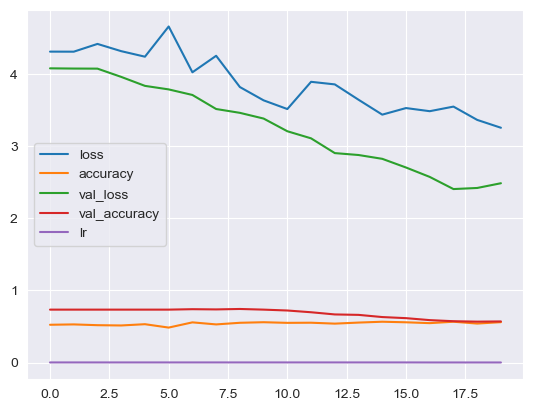

In [8]:
losses = pd.DataFrame(model.history.history)
losses.plot()

#### Biểu đồ thể hiện loss và accuracy

   * Hàm loss biểu thị mức độ lỗi của mô hình trong quá trình học tập
   * Hàm accuracy biểu thị mức độ chính xác của mô hình trong việc dự đoán các dữ liệu trong tập kiểm tra.

In [9]:
probabilities = model.predict(x_test)
predictions = np.argmax(probabilities, axis=-1)
model.evaluate(x_test,y_test)

11/11 [==============================] - 0s 1ms/step - loss: 3.4621 - accuracy: 0.7424


[3.4621496200561523, 0.7424242496490479]

In [10]:
model.evaluate(x_test,y_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

11/11 [==============================] - 0s 1ms/step - loss: 3.4621 - accuracy: 0.7424
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

[[242   0]
 [ 88   0]]


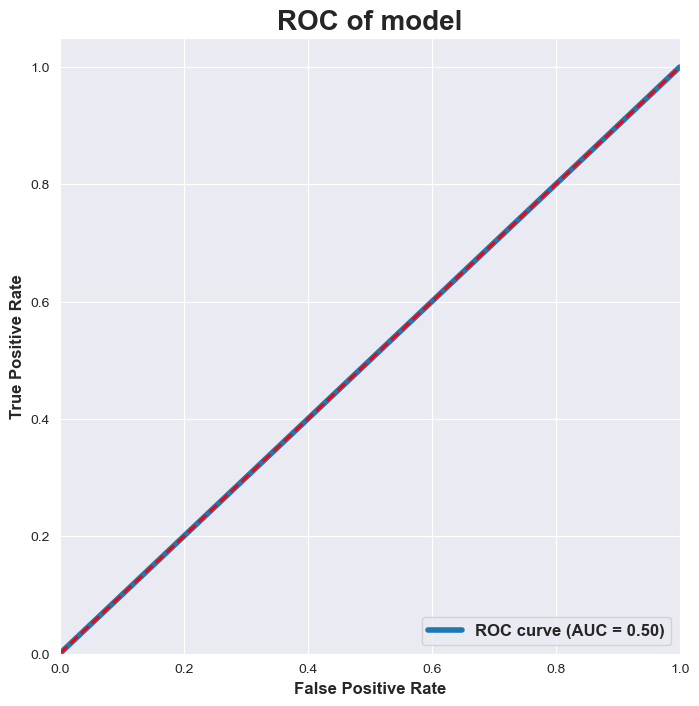

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

### Nhận xét

   * Ta thấy **accuracy: 0.74**. Đây là tỷ lệ mẫu được dự đoán đúng trên tổng số mẫu. Tuy nhiên, vì tập dữ liệu của nhóm mất cân bằng lớp (lớp 0 có 239 mẫu, trong khi lớp 1 (gian lận) chỉ có 85 mẫu), Accuracy có thể không phản ánh chính xác vì mô hình có thể dự đoán một lớp nhiều hơn.
   
   * Các chỉ số **precision, recall, f1-score của lớp 1 đều =0.00**, Điều này có nghĩa là mô hình không tìm thấy dự đoán đúng cho lớp gian lận, không đạt được hiệu suất tốt trên lớp ít xuất hiện này. => Mô hình có vấn đề trong việc dự đoán lớp 1. 

### Kết luận:
- Nhóm xây dựng một mạng Netual network ứng dụng kỹ thuật trong học sâu như callbacks, đánh trọng số,.... Nhưng không khắc phục được tình trạng (imbalanced variable).

In [12]:
def check_result(prediction):
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [13]:
def check_output(stt,model, X_test, Y_test):
    print(f"Lần thứ {stt}: ")
    indx = rd.randint(0, X_test.shape[0] - 1)  # Đảm bảo indx nằm trong giới hạn của DataFrame
    sample = X_test.iloc[indx, :].values        # Chuyển DataFrame thành mảng NumPy
    sample = np.expand_dims(sample, axis=0)     # Mở rộng kích thước cho phù hợp với mô hình
    y_predict = model.predict(sample)
    print(y_predict)
    Y_check = check_result(Y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict))
    print("----------------------------")
    if Y_check==check_result(y_predict):
        return True
    else: return False
    
    

In [14]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    sample = x_test.iloc[indx, :].values        # Chuyển DataFrame thành mảng NumPy
    sample = np.expand_dims(sample, axis=0)     # Mở rộng kích thước cho phù hợp với mô hình
    y_predict = model.predict(sample)
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict))
    print("----------------------------")
    if Y_check==check_result(y_predict):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

1/1 [==============================] - 0s 101ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 20ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 16ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 15ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 15ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 15ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 14ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 14ms/step
True: Y
Predicted: N
----------------------------
1/1 [==============================] - 0s 15ms/step
True: N
Predicted: N
----------------------------
1/1 [==============================] - 0s 16ms/step
True: N
Predicted: N
--------

In [15]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 242 chiếm khoảng 73.33333333333333% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế


* Ta có thể thấy trong tất cả các lần dự đoán, mô hình đều dự đoán 'N'(lớp 0). Đó là lí do tại sao chỉ số 'accuracy'lại cao như vậy ( vốn tập dữ liệu bị mất cân bằng lớp lớp 0 gấp 3 lần lớp 1)

#### => Kết luận: Ta không dựa vào chỉ số 'accuracy' để đánh giá các mô hình.